In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing import text, sequence


/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [69]:
pd.set_option('display.max_colwidth', 362)
pd.set_option('display.max_rows', 100)

In [34]:
label_cols=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [2]:
EMBEDDING_FILE = 'adfasfad'#'/home/kai/data/resources/glove/glove.840B.300d.txt' #glove.twitter.27B.200d.txt
PATH = '~/data/toxic/data/'
# train = pd.read_csv(PATH + 'train.csv')
# test = pd.read_csv(PATH + 'test.csv')
# train = pd.read_csv(PATH + 'cleaned_train.csv')
# test = pd.read_csv(PATH + 'cleaned_test.csv')
train = pd.read_csv(PATH + 'train_preprocessed.csv')
test = pd.read_csv(PATH + 'test_preprocessed.csv')

In [3]:
train_ori = pd.read_csv(PATH + 'train.csv')

train = train.merge(train_ori[['comment_text', 'id']], on='id', suffixes=('', '_ori'))

train_cleaned = pd.read_csv(PATH + 'cleaned_train.csv')

train = train.merge(train_cleaned[['comment_text_cleaned', 'id']], on='id')

In [101]:
test_ori = pd.read_csv(PATH + 'test.csv')

test = test.merge(test_ori[['comment_text', 'id']], on='id', suffixes=('', '_ori'))

test_cleaned = pd.read_csv(PATH + 'cleaned_test.csv')

test = test.merge(test_cleaned[['comment_text_cleaned', 'id']], on='id')

In [116]:
test.drop(label_cols, axis=1, inplace=True) # the preprocessed file contains label columns with value NaN, so drop them

In [7]:
train.head(1)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity,comment_text_ori,comment_text_cleaned
0,explanation why the edits made under my userna...,0000997932d777bf,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0,Explanation\nWhy the edits made under my usern...,explanation why the edit make under my usernam...


In [8]:
def word2Vec(source):
    embed_size = 300
    if source.lower() == 'ft-common':
        file = '/home/kai/data/resources/FastText/crawl-300d-2M.vec'
    elif source.lower() == 'ft-wiki':
        file = '/home/kai/data/resources/FastText/wiki.en.vec'
    elif source.lower() == 'lex':
        file = '/home/kai/data/resources/lexvec/lexvec.commoncrawl.300d.W.pos.vectors'
    elif source.lower() == 'gl-common':
        file = '/home/kai/data/resources/glove/glove.840B.300d.txt'
    elif source.lower() == 'gl-twitter':
        file = '/home/kai/data/resources/glove/glove.twitter.27B.200d.txt'
        embed_size = 200
    def get_coefs(word,*arr): 
        try:
            return word, np.asarray(arr, dtype='float32') 
        except ValueError:
            return 'nnnnnnnaaaaaaa@@!',np.zeros(embed_size)
    embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(file, encoding='utf8'))
    return embeddings_index, embed_size

In [6]:
# embeddings_index_lex, embed_size = word2Vec('lex')

# embeddings_index_glc, embed_size = word2Vec('gl-common')

In [9]:
max_features=100000
maxlen=150

In [10]:
embeddings_index_glt, embed_size = word2Vec('gl-twitter')

In [11]:
comment_col = 'comment_text' # 'comment_text_cleaned' 

X_train = train[comment_col].str.lower().fillna('something') # something is a word of neutral sentiment
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

X_test = test[comment_col].str.lower().fillna('something')

In [12]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [7]:
tok.word_counts['niggors']

554

In [13]:
tok.word_counts['sockpuppets']

545

In [26]:
tok.word_counts['buttsecks']

499

In [14]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
not_found_word = {}
for word, i in word_index.items():
    if i >= max_features:
        continue
    try: 
        embedding_vector = embeddings_index_glt[word] # w2v_model['/en/'+ word] #w2v_model[word]#
    except KeyError:
        embedding_vector = None #np.zeros(embed_size)
        not_found_word[word] = tok.word_counts[word]#i
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(len(not_found_word))

32259


In [15]:
word_counts_sorted = sorted(tok.word_counts.items(), key=lambda x: x[1], reverse=True)

In [16]:
morethansth = [count for count in not_found_word.values() if count > 200]
len(morethansth)

119

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([45., 25., 18.,  9.,  4.,  2.,  1.,  4.,  1.,  0.,  1.,  1.,  2.,
         1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.]),
 array([ 201.        ,  313.93333333,  426.86666667,  539.8       ,
         652.73333333,  765.66666667,  878.6       ,  991.53333333,
        1104.46666667, 1217.4       , 1330.33333333, 1443.26666667,
        1556.2       , 1669.13333333, 1782.06666667, 1895.        ,
        2007.93333333, 2120.86666667, 2233.8       , 2346.73333333,
        2459.66666667, 2572.6       , 2685.53333333, 2798.46666667,
        2911.4       , 3024.33333333, 3137.26666667, 3250.2       ,
        3363.13333333, 3476.06666667, 3589.        ]),
 <a list of 30 Patch objects>)

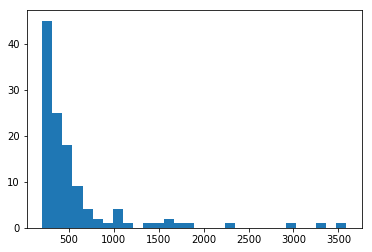

In [18]:
plt.hist(morethansth, bins = 30)

In [19]:
chosen_set = set([w for w,count in not_found_word.items() if count > 120])

In [20]:
len(chosen_set)

215

In [22]:
list(chosen_set)[:10]

['penispenis',
 'pagedelete',
 'encyclopaedic',
 'sexsex',
 'ballsballs',
 'copyedit',
 'adminship',
 'hyehuh',
 'wikipedias',
 'macedonians']

In [23]:
not_found_word_sorted = sorted(not_found_word.items(), key=lambda x:x[1], reverse=True)

In [24]:
not_found_word_sorted

[('wikiproject', 3589),
 ('npov', 3348),
 ('contribs', 2996),
 ('infobox', 2284),
 ('barnstar', 1884),
 ('sockpuppet', 1688),
 ('unsourced', 1664),
 ('wikipedians', 1619),
 ('disambiguation', 1537),
 ('lation', 1334),
 ('cellpadding', 1105),
 ('verifiability', 1088),
 ('arbcom', 1034),
 ('userpage', 1033),
 ('dixz', 1000),
 ('talkpage', 976),
 ('rowspan', 866),
 ('gfdl', 770),
 ('oldid', 720),
 ('helloz', 713),
 ('cellspacing', 711),
 ('sockpuppetry', 668),
 ('mathman', 625),
 ('yourselfgo', 621),
 ('roycy', 598),
 ('unconstructive', 584),
 ('roflspam', 555),
 ('niggors', 554),
 ('sockpuppets', 545),
 ('valign', 542),
 ('mainpagebg', 540),
 ('copyvio', 530),
 ('adminship', 508),
 ('bonergasm', 500),
 ('buttsecks', 499),
 ('donkeysex', 492),
 ('deletions', 492),
 ('mothjer', 489),
 ('phck', 489),
 ('checkuser', 480),
 ('fdffe', 474),
 ('vandalizer', 466),
 ('conformance', 463),
 ('godstars', 461),
 ('titoxd', 460),
 ('faggt', 456),
 ('cucks', 451),
 ('reedelliot', 442),
 ('unreferenced'

In [32]:
# for embed in [embeddings_index_glc, embeddings_index_glt, embeddings_index_lex]:
#     for k in bad_word_saver.keys():
#         try:
#             embed[k]
#             print(k)
#         except:
#             pass
#     print('----------')

In [35]:
train['having_pos_label'] = train.apply(lambda row: sum(row[label_cols]), axis=1)

In [36]:
train.head(1)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity,comment_text_ori,comment_text_cleaned,having_pos_label
0,explanation why the edits made under my userna...,0000997932d777bf,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0,Explanation\nWhy the edits made under my usern...,explanation why the edit make under my usernam...,0.0


In [37]:
len(train[train['having_pos_label'] != 0]) # having at least 1 pos label

16225

In [41]:
train['splited'] = train['comment_text'].fillna('something').apply(lambda x: x.split())
test['splited'] = test['comment_text'].fillna('something').apply(lambda x: x.split())

In [44]:
train_having_pos_label = train[train['having_pos_label'] != 0]

In [42]:
def check_list(row, word_check_list):
    contains = set()
    for w in row['splited']:
        if w in word_check_list:
            contains.add(w)
    contains = list(contains)
    if len(contains) > 0:
        positive_label_score = row['having_pos_label']
        if positive_label_score != 0:
            # redundant to add 'postive label' column, but leave it here to show how.
            return pd.Series({'contains':contains, 'positive label':positive_label_score}) 
        else:
            return pd.Series({'contains':contains, 'positive label':0})
    else:
        return pd.Series({'contains':'NONE', 'positive label':0})

In [43]:
# train_having_pos_label = train_having_pos_label.merge(train_having_pos_label.apply(
#     lambda row: check_list(row, chosen_set), axis=1), left_index=True, right_index=True)

In [45]:
train.head(1)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity,comment_text_ori,comment_text_cleaned,having_pos_label,splited,contains,positive label
0,explanation why the edits made under my userna...,0000997932d777bf,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0,Explanation\nWhy the edits made under my usern...,explanation why the edit make under my usernam...,0.0,"[explanation, why, the, edits, made, under, my...",NONE,0.0


In [48]:
analysis_containing_all = train[train['contains'] != 'NONE'][['comment_text_ori', 'contains', 'positive label']]

In [49]:
len(analysis_containing_all)

17832

In [54]:
analysis_containing_and_pos_label = train[(train['contains'] != 'NONE') & (train['having_pos_label'] > 0)][['comment_text_ori', 'contains', 'positive label']]

In [55]:
len(analysis_containing_and_pos_label) # something to analyze

884

In [93]:
def found_word(word_list, word):
    word_list = set(word_list)
    if word in word_list:
        return True
    else:
        return False

In [24]:
test[comment_col] = test[comment_col].str.lower().fillna('something')

In [25]:
test['splited'] = test['comment_text'].apply(lambda x: x.split())

In [106]:
# preds of twitter embedding
preds_glt = pd.read_csv('~/data/shiyi/Kaggle/toxic/sc/stacking/StackPreds/TopN_XGB/9832_rnn_w_conv_twitter_1520460207.csv')

test_glt = test.merge(preds_glt, on='id')

In [188]:
def analyze_word(the_word, verbose=True):
    appear_total_times = tok.word_counts[the_word]
    train['found'] = train['splited'].apply(lambda x: found_word(x, the_word))
    appearsin_comments_in_train = sum(train['found'])
    negative_comments = sum((train.found) & (train.having_pos_label))
    if appearsin_comments_in_train != 0:
        negative_ratio = negative_comments/appearsin_comments_in_train
    else:
        negative_ratio = 0
    test_glt['found'] = test_glt['splited'].apply(lambda x: found_word(x, the_word))
    appearsin_comments_in_test = sum(test_glt['found'])
   
    if verbose:
        print('the word "{}" appears {} times in training and testing'.format(the_word, appear_total_times)) # number of times the word appears
        print('it appears in {} comments in training data'.format(appearsin_comments_in_train))# number of document the word appears in train
        print('{} of these comments have at least one positive labels (negative comment). Negative ratio: {:.3f}%'.format(negative_comments, negative_ratio*100))
        print('it appears in {} comments in testing data'.format(appearsin_comments_in_test)) # number of document the word appears in test
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
 
    return appear_total_times, appearsin_comments_in_train, negative_comments, negative_ratio, appearsin_comments_in_test

In [133]:
word_analysis = {}
for the_word in chosen_set:
    word_analysis[the_word] = analyze_word(the_word) #, verbose=False)

the word "penispenis" appears 127 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "pagedelete" appears 312 times in training and testing
it appears in 1 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 0 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "encyclopaedic" appears 165 times in training and testing
it appears in 84 comments in training data
7 of these comments have at least one positive labels (negative comment). Negative ratio: 8.333%
it appears in 72 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "sexsex" appears 337 times

the word "i'm" appears 332 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 221 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "bonergasm" appears 500 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "checkuser" appears 480 times in training and testing
it appears in 228 comments in training data
15 of these comments have at least one positive labels (negative comment). Negative ratio: 6.579%
it appears in 153 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "headsdick" appears 157 times in 

the word "analanal" appears 362 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "swyers" appears 356 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "bgcolor" appears 378 times in training and testing
it appears in 9 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 51 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "cluebot" appears 159 times in training

the word "neutrally" appears 166 times in training and testing
it appears in 90 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 1.111%
it appears in 65 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "fdffe" appears 474 times in training and testing
it appears in 18 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 5.556%
it appears in 441 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "tabtab" appears 127 times in training and testing
it appears in 50 comments in training data
5 of these comments have at least one positive labels (negative comment). Negative ratio: 10.000%
it appears in 0 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "faggt" appears 456 times in train

the word "allumungi" appears 153 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "disambig" appears 209 times in training and testing
it appears in 84 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 1.190%
it appears in 91 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "lation" appears 1334 times in training and testing
it appears in 501 comments in training data
11 of these comments have at least one positive labels (negative comment). Negative ratio: 2.196%
it appears in 507 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "lolzblack" appears 130 times 

the word "delanoy" appears 223 times in training and testing
it appears in 27 comments in training data
18 of these comments have at least one positive labels (negative comment). Negative ratio: 66.667%
it appears in 18 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "rabbitowenx" appears 124 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "concensus" appears 185 times in training and testing
it appears in 104 comments in training data
6 of these comments have at least one positive labels (negative comment). Negative ratio: 5.769%
it appears in 52 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "copyediting" appears 188 t

the word "centraliststupid" appears 179 times in training and testing
it appears in 1 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 100.000%
it appears in 0 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "barnstars" appears 141 times in training and testing
it appears in 65 comments in training data
6 of these comments have at least one positive labels (negative comment). Negative ratio: 9.231%
it appears in 54 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "niggors" appears 554 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "afghooni" appears 397 ti

the word "owein" appears 147 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "rhinehart" appears 203 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "shimgray" appears 168 times in training and testing
it appears in 1 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 100.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "misterwiki" appears 241 times in tra

the word "phck" appears 489 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 2 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "subpage" appears 280 times in training and testing
it appears in 127 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 0.787%
it appears in 99 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "wikilove" appears 317 times in training and testing
it appears in 104 comments in training data
1 of these comments have at least one positive labels (negative comment). Negative ratio: 0.962%
it appears in 84 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
the word "vaginapenis" appears 333 times in t

In [150]:
word_analysis_sorted = sorted(word_analysis.items(), key=lambda x: x[1][3], reverse=True)

In [151]:
word_analysis_sorted

[('sexsex', (337, 1, 1, 1.0, 1)),
 ('supertr', (224, 4, 4, 1.0, 2)),
 ('fuckerucker', (161, 11, 11, 1.0, 35)),
 ('buttsecks', (499, 2, 2, 1.0, 1)),
 ('mothjer', (489, 5, 5, 1.0, 0)),
 ('youbollocks', (217, 1, 1, 1.0, 0)),
 ('nhrhs', (199, 6, 6, 1.0, 3)),
 ('bunksteve', (278, 1, 1, 1.0, 0)),
 ('bleachanhero', (148, 1, 1, 1.0, 0)),
 ('yourselfgo', (621, 2, 2, 1.0, 0)),
 ('aidsaids', (146, 1, 1, 1.0, 0)),
 ('criminalwar', (279, 1, 1, 1.0, 0)),
 ('centraliststupid', (179, 1, 1, 1.0, 0)),
 ('shimgray', (168, 1, 1, 1.0, 1)),
 ('notrhbysouthbanof', (308, 3, 3, 1.0, 0)),
 ('marcol', (264, 2, 2, 1.0, 0)),
 ('mattythewhite', (147, 6, 5, 0.8333333333333334, 2)),
 ('ullmann', (187, 3, 2, 0.6666666666666666, 1)),
 ('delanoy', (223, 27, 18, 0.6666666666666666, 18)),
 ('ytmnd', (258, 9, 5, 0.5555555555555556, 5)),
 ('njgw', (145, 8, 4, 0.5, 5)),
 ('misterwiki', (241, 5, 2, 0.4, 1)),
 ('semite', (126, 58, 19, 0.3275862068965517, 47)),
 ('curps', (417, 20, 6, 0.3, 16)),
 ('cluebot', (159, 36, 10, 0.277

In [198]:
type(embeddings_index_glt['dick']) # don't care the vector, just to check if exist

numpy.ndarray

In [302]:
bad_word_dict1 = {
    'niggors': 'nigger', # stem + spell check
    'mothjer': 'mother', # spell check (stem is ok)
    'faggt':'faggot',
    'cucks':'cocks', # spell check 
    'sexsex': 'sex',
    'peenus': 'penis',
    'sexsex': 'sex',
    'fuckerucker': 'fucker', 
    'sockpuppet':'alias',
    'sockpuppetry': 'alias',
    'semite':'semitic',
    'donkeysex':'dick',
    'homopetersymonds': 'homo',
    'headsdick': 'dick',
    'peni':'penis',
    'asspie':'ass',
    'nonense': 'nonsense',
    'vagpenis':'penis',
    'diedres': 'crap',
    'niggetr': 'nigger'
}

In [310]:
bad_word_dict2 ={
    'youfuck': 'fuck',
    'niggors' :'nigger',
    'bitchbot': 'bitch',
    'donkeysex': 'dick',
    'motherfuc': 'motherfucker',
    'sexualit': 'sexuality',
    'sexuall': 'sexual',
    'cocain': 'cocaine',
    "fuck'": 'fuck',
    'valentin': 'valentine',
    'decease': 'deceased',
    'deth': 'death',
    "'ass": 'ass',
    'gayy': 'gay',
    'sexe': 'sex',
    'bith': 'bitch',
    'bithc': 'bitch',
    'bithces': 'bitch',
    "fool'": 'fool',
    'cuck': 'cock',
    "'shit": 'shit',
    "penis'": 'penis',
    "bitch'": 'bitch',
    "'stupid": 'stupid',
    'fuckn': 'fuck',
    'choked': 'choke',
    'headsdick': 'dick',
    'peni': 'penis',
    'asspie': 'ass',
    'nonense': 'nonsense',
    'nonsesnse': 'nonsense',
    'zdick': 'dick',
    'asse': 'ass',
    'vagpenis': 'penis',
    'niggetr': 'nigger',
    "mother's": 'mother',
    'pornn': 'porn',
    'fuock': 'fuck',
    'dik': 'dick',
    'maoth': 'mouth',
    'horsecock': 'cock',
    'pneis': 'penis',
    'mothjer': 'mother'
}

In [311]:
bad_word_dict2.update(bad_word_dict1)

In [312]:
bad_word_dict2

{"'ass": 'ass',
 "'shit": 'shit',
 "'stupid": 'stupid',
 'asse': 'ass',
 'asspie': 'ass',
 "bitch'": 'bitch',
 'bitchbot': 'bitch',
 'bith': 'bitch',
 'bithc': 'bitch',
 'bithces': 'bitch',
 'choked': 'choke',
 'cocain': 'cocaine',
 'cuck': 'cock',
 'cucks': 'cocks',
 'decease': 'deceased',
 'deth': 'death',
 'diedres': 'crap',
 'dik': 'dick',
 'donkeysex': 'dick',
 'faggt': 'faggot',
 "fool'": 'fool',
 "fuck'": 'fuck',
 'fuckerucker': 'fucker',
 'fuckn': 'fuck',
 'fuock': 'fuck',
 'gayy': 'gay',
 'headsdick': 'dick',
 'homopetersymonds': 'homo',
 'horsecock': 'cock',
 'maoth': 'mouth',
 "mother's": 'mother',
 'motherfuc': 'motherfucker',
 'mothjer': 'mother',
 'niggetr': 'nigger',
 'niggors': 'nigger',
 'nonense': 'nonsense',
 'nonsesnse': 'nonsense',
 'peenus': 'penis',
 'peni': 'penis',
 "penis'": 'penis',
 'pneis': 'penis',
 'pornn': 'porn',
 'semite': 'semitic',
 'sexe': 'sex',
 'sexsex': 'sex',
 'sexualit': 'sexuality',
 'sexuall': 'sexual',
 'sockpuppet': 'alias',
 'sockpuppetry

In [314]:
# check the comments containing a specific word
the_word = "fuock"
analyze_word(the_word)
train[train.found][['comment_text_ori']+label_cols].head(10)

the word "fuock" appears 17 times in training and testing
it appears in 0 comments in training data
0 of these comments have at least one positive labels (negative comment). Negative ratio: 0.000%
it appears in 1 comments in testing data
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


,comment_text_ori,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [316]:
test_glt[test_glt.found][['comment_text','comment_text_cleaned','comment_text_ori']+label_cols].head(10)

,comment_text,comment_text_cleaned,comment_text_ori,toxic,severe_toxic,obscene,threat,insult,identity_hate
95388,fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuoc...,fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuock you ponyo let your mom play with my dik in her maoth fuoc...,fuOck you Ponyo let your mom play with my dik in her maoth \n\n fuOck you Ponyo let your mom play with my dik in her maoth \n\n fuOck you Ponyo let your mom play with my dik in her maoth \n\n fuOck you Ponyo let your mom play with my dik in her maoth \n\n fuOck you Ponyo let your mom play with my dik in her maoth \n\n fuOck you Ponyo let your mom play with...,0.595704,0.055176,0.094654,0.033333,0.042628,0.014651


In [173]:
cor = pd.read_csv('/home/kai/data/wei/Toxic/dataset/word_correlation_wordIndex.csv')

In [248]:
cor.sort_values(by='toxic', ascending=False).head(100)

,Unnamed: 0,word,toxic,severe_toxic,obscene,threat,insult,identity_hate
93569,93569,motherfucker,0.092819,0.127510,0.122738,0.046465,0.111443,0.053441
35994,35994,crap,0.082651,0.005992,0.058576,0.007024,0.035877,0.006310
56164,56164,fuck,0.073932,0.154652,0.100364,0.011927,0.084663,0.025683
110969,110969,prick,0.072419,0.046255,0.072925,0.025261,0.075174,0.019753
108103,108103,piss,0.065519,0.017767,0.058895,0.014653,0.045207,0.012230
64288,64288,hell,0.059566,0.032157,0.035273,0.017612,0.046936,0.011936
96886,96886,nerd,0.059294,0.036786,0.055022,0.009056,0.061467,0.017528
82872,82872,life,0.057802,0.030794,0.043936,0.014650,0.053649,0.015325
127104,127104,sick,0.057480,0.003934,0.031499,-0.000868,0.036943,0.014152
74404,74404,jerk,0.057282,0.017780,0.052172,0.004669,0.057206,0.007331


# libraries of steming, lemmatization, spellcheck, string distance

In [96]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer() 

In [203]:
wnl.lemmatize('niggors')

'niggors'

In [215]:
from nltk.stem.porter import *
#stemmer = PorterStemmer() # worse

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english") # better

In [217]:
stemmer.stem('niggors')

'niggor'

In [250]:
stemmer.stem('mothjer')

'mothjer'

In [44]:
compare_word('nigger', "nigga'")

2

In [158]:
from textblob import Word

In [159]:
Word("semite").spellcheck()

[('smite', 1.0)]

In [57]:
from  Levenshtein import distance
vocalbulary = pd.Series(list(embeddings_index_lex.keys())) 
def compare_word(x,target):
    return distance(x, target)

ss = vocalbulary.apply(compare_word, args=("b*tch",)).sort_values().index[:10]
vocalbulary[ss] 

236995     batch
303297     bjtch
1943014    bitch
1550674     btch
969427     bxtch
284704     b0tch
1022164    bytch
797301     bktch
1908322    butch
464086     betch
dtype: object

In [42]:
ss = vocalbulary.apply(compare_word, args=("nigga'",)).sort_values()